In [3]:
import math
import copy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid

# Backpropagation

## Context
With the democratization of deep learning and the introduction of open source tools like Tensorflow or Keras, you can nowadays train [a convolutional neural network to classify image of dogs and cats with just some knowledge about Python](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb
). Unfortunately, these tools tend to abstract the hard part away from us, and we are then tempted to skip the understanding of the “inner mechanics” . In particular, not understanding “backpropagation”, the bread and butter of deep learning, would most probably lead you to badly design your networks. In a [Medium article](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b
), Andrej Karpathy, now director of AI at Tesla, listed few reasons why you should understand backpropagation. Problems such as vanishing and exploding gradients, or dying relus are some of them. Backpropagation is not a very complicated algorithm, and with some knowledge about calculus especially the chain rules, it can be understood pretty quickly. 

Neural networks, like any other supervised learning algorithms, learn to map an input to an output based on some provided examples of (input, output) pairs, called the training set. In particular, neural networks performs this mapping by processing the input through a set of transformations like illustrated below:

<img src="files/static/images/neural_network.png">

In the picture above, the input is transformed first through the hidden layer 1, then the second one and finally an output is predicted. Each transformation is controlled by a set of weights (and biases). During training, to indeed “learn” something, the network needs to adjust these weights to minimize the error (also called the loss function) between the expected outputs and the ones it maps from the given inputs. Using [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) as an optimization algorithm, the weights are updated at each iteration as:

$ w^{(n+1)} = w^{(n)} - \epsilon \frac{\partial L}{\partial w} $, where L is the loss function and $\epsilon$ is the learning rate. 

As we can see above, the gradient of the loss with respect to the weight is substracted to this weight at each iteration. This is the so called "gradient descent". The gradient of the loss with respect to the weight $\frac{\partial L}{\partial w} $ can be interpreted as a measure of the contribution of the weight to the loss. Therefore the more the weight contribute to the loss, the more its value is going to change.

The minimization of the loss function task ends up being related to the evaluation of the gradients described above. We will review 3 proposals to perform this evaluation:

* Analytical calculation of the gradients.
* Approximation of the gradients as being: $ \frac{\partial L}{\partial w} = \frac{L(w + \delta w) - L(w)}{\delta w}$, where $\delta w \rightarrow 0$.
* Backpropagation or reverse mode autodiff.

But first let's simplify a little bit our discussion and define clearly our problem.

## Problem definition

To simplify our discussion, we will consider that each layer of the network is made of a single unit, and that we have a single hidden layer. The network looks now like: 

<img src="static/images/neural_network_1D.png">

Let's discuss a little bit about how the input is transformed to produce the hidden layer representation. In neural network, a layer is obtained by performing two operations on the previous layer:

* First the previous layer is tranformed via a linear operation: the value of the previous layer is multiplied by a weight, and a bias is added to it. It gives:
$z = xw + b$, where x is the value of the previous layer unit, w and b are respectively the weight and the bias discussed above.
* Second, the previous linear operation is used as an input to the activation function of the unit. This activation is generally chosen to introduce non linearity in order to solve complex tasks. Here we will simply consider that this activation function is a sigmoid function: $\sigma(x) = \frac{1}{1+\exp(-x)}$. As a consequence the value y of a layer can be written as:
$ y = \sigma (z) = \sigma (xw + b)$, with x, w and b defined as above.

So now, considering our case, with an input layer, one hidden layer, and an output layer, all made of a single unit and respectively called x, h and y, we can write:

$ h = \sigma (xw_1 + b_1) $, where $w_1$ and $b_1$ are respectively the weight and the bias use to compute the hidden unit from the input.

$ y = \sigma (hw_2 + b_2) $, where $w_2$ and $b_2$ are respectively the weight and the bias use to compute the output from the hidden unit.

From now on, we are able to calculate the output y based on the input x, through a set of transformations. This is the so called forward propagation since this calculation goes forward inside the network.

To evaluate how good is the predicted output, we need to compare it to the true one $y_T$. Here we will consider as a loss function (the function that quantify the error the network does trying to predict $y_T$) the squared error defined as :

$ L = \frac{1}{2} (y-y_T)^2 $

As discussed earlier, the weights (and biases) need to be updated according to the gradient of this loss function L with respect to these weights (and biases). Therefore the challenge here is to evaluate these gradients. The first approach would be to manually derive them.

## Analytical differentiation
Although this method is cumbersome and error prone, it is worth to investigate to illustrate the problem. Here we simplify a lot the problem since we have a single hidden layer and a single unit per layer. And yet the analytical derivation requires quite some attention.

$ 
\begin{equation} 
    \begin{split}
        \frac{\partial L}{\partial w_2} & = \frac{1}{2} \frac{\partial \left((y-y_T)^2\right)}{\partial w_2} \\
                                        & = \frac{1}{2} \left(\frac{\partial \left(y^2\right)}{\partial w_2} - 2y_T \frac{\partial y}{\partial w_2}\right)\\
    \end{split}
\end{equation}
$

Knowing that $ y = \sigma (hw_2 +b_2) $, we get :

$ 
\begin{equation} 
    \begin{split}
        \frac{\partial L}{\partial w_2} & = \frac{1}{2} \left(\frac{\partial \left(\frac{1}{\left( 1 + \exp(-hw_2 -b_2\right))^2}\right)}{\partial w_2} - 2y_T \frac{\partial \frac{1}{1 + \exp(-hw_2 - b_2)}}{\partial w_2}\right) \\
                                        & = \frac{h \exp(-hw_2 - b_2)}{\left(1+\exp(-hw_2 - b_2)\right)^3} - \frac{y_T h \exp(-hw_2 - b_2)}{\left(1+\exp(-hw_2 - b_2)\right)^2} \\
                                        & = h\frac{ \exp(-hw_2 - b_2)}{\left(1+\exp(-hw_2 - b_2)\right)^2} \left(\frac{1}{1+\exp(-hw_2 - b_2)} - y_T\right)
    \end{split}
\end{equation}
$

Here we derived the gradient with respect to $w_2$, and the calculation for the one with respect with $w_1$ would be even more tedious. Therefore such an analytical approach would be very hard to implement for a complex network. In addition, computingly wise this approach would be quite unefficient since we could not leverage the fact that the gradients share some common definition as we have seen above. A way more easy way to get these gradients would be to use a numerical approximation.

## Numerical differentiation

Trading accuracy with simplicity, we can obtain the gradient using the following :

$ 
\begin{equation} 
    \begin{split}
        \frac{\partial L}{\partial w} \simeq \frac{L(w + \delta w) - L(w)}{\delta w}, \space with \space\delta w \rightarrow 0
    \end{split}
\end{equation}
$

As suggested above, although simpler than the analytical derivation, this numerical differentiation is also less precise. In addition for every gradients to evaluate, we would have to calculate the loss function at least once (doing one forward pass by weights and biases). For a neural network with 1 million weigth parameters, it would requires 1 million forward passes, which is definitely not efficient computingly wise. Let's now come to a better solution and the core of this article by reviewing the backpropagation approach.

# Backpropagation
Before speaking in more details about what backpropagation is, let's first introduce the computational graph that leads to the evaluation of the loss function.

<img src="static/images/computational_graph.png">

The nodes in this graph correspond to all the values that are computed in order to get the loss L. If a variable is computed by applying an operation to another variable, an edge is drawn between the two variable nodes. Looking at this graph, and making use of the chain rule of calculus, we can express the gradient of L with respect to the weights (or biases) as:

$ 
\begin{equation} 
    \begin{split}
        \frac{\partial L}{\partial w_2} & = \frac{\partial L}{\partial y} \frac{\partial y}{\partial w_2}\\
                                        & = \frac{\partial L}{\partial y} \frac{\partial y}{\partial z_2} \frac{\partial z_2}{\partial w_2} \\
    \end{split}
\end{equation}
$


Same goes for the weight $ w_1 $:

$ 
\begin{equation} 
    \begin{split}
        \frac{\partial L}{\partial w_1} & = \frac{\partial L}{\partial y} \frac{\partial y}{\partial w_1}\\
                                        & = \frac{\partial L}{\partial y} \frac{\partial y}{\partial z_2} \frac{\partial z_2}{\partial w_1} \\
                                        & = \frac{\partial L}{\partial y} \frac{\partial y}{\partial z_2} \frac{\partial z_2}{\partial h} \frac{\partial h}{\partial w_1} \\
                                        & = \frac{\partial L}{\partial y} \frac{\partial y}{\partial z_2} \frac{\partial z_2}{\partial h} \frac{\partial h}{\partial z_1} \frac{\partial z_1}{\partial w_1}
    \end{split}
\end{equation}
$

One very important thing to notice here is that the evaluation of the gradient $\frac{\partial L}{\partial w_1}$ can reuse some of the calculations perfomed during the evaluation of the gradient $\frac{\partial L}{\partial w_2}$. It is even clearer if we evaluate the gradient $\frac{\partial L}{\partial b_1}$:

$ 
\begin{equation} 
    \begin{split}
        \frac{\partial L}{\partial b_1} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial z_2} \frac{\partial z_2}{\partial h} \frac{\partial h}{\partial z_1} \frac{\partial z_1}{\partial b_1}
    \end{split}
\end{equation}
$

We see that the first four term on the righ hand of the equation are the same than the one from $\frac{\partial L}{\partial w_1}$.


As you can see in the equations above, we calculate the gradient starting from the end of the computational graph, and proceed backward to get the gradient of the loss with respect to the weights (or the biases). This backward evaluation gives its name to the algoritm: backpropagation.

In practice, one iteration of gradient descent would now require one forward pass, and only one pass in the reverse direction computing all the partial derivatives starting from the output node. It is therefore way more efficient than the previous approaches.

To visualize better what backpropagation is in practice, let's implement a neural network classification problem in bare numpy. Indeed as we will see below, there is no need of a complex deep learning library to play at first with a neural network.

## A toy problem
Let's consider a binary classification problem where the task is about predict the class of a given input.

### The dataset
As a dataset, we chose a pretty standard not linearly separable dataset made of two classes "0" and "1". 

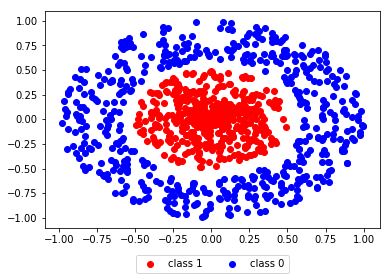

In [20]:
np.random.seed(0)

def generate_dataset(N_points):
    data = []
    labels = []
    
    # 1 class
    radiuses = np.random.uniform(0, 0.5, size=N_points//2)
    angles = np.random.uniform(0, 2*math.pi, size=N_points//2)
    
    x_1_1 = np.multiply(radiuses, np.cos(angles)).reshape(N_points//2, 1)
    x_1_2 = np.multiply(radiuses, np.sin(angles)).reshape(N_points//2, 1)
    x_1 = np.concatenate((x_1_1, x_1_2), axis=1)
    y_1 = np.full((N_points//2,), 1)
        
    # 0 class
    radiuses = np.random.uniform(0.6, 1, size=N_points//2)
    angles = np.random.uniform(0, 2*math.pi, size=N_points//2)
    
    x_2_1 = np.multiply(radiuses, np.cos(angles)).reshape(N_points//2, 1)
    x_2_2 = np.multiply(radiuses, np.sin(angles)).reshape(N_points//2, 1)
    x_2 = np.concatenate((x_2_1, x_2_2), axis=1)
    y_2 = np.full((N_points//2,), 0)
        
    X = np.concatenate((x_1, x_2), axis=0)
    Y = np.concatenate((y_1, y_2), axis=0)
    return X, Y
    
N_points = 1000
X, Y = generate_dataset(N_points)

plt.scatter(X[:N_points//2, 0], X[:N_points//2, 1], color='red', label='class 1') 
plt.scatter(X[N_points//2:, 0], X[N_points//2:, 1], color='blue', label='class 0')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()

### The neural network
As we can see from the dataset above, the data point are defined as $ 
\begin{equation} 
    \begin{split}
        \mathbf{x} = 
                        \begin{bmatrix}
                            x_1 \\
                            x_2 \\
                        \end{bmatrix}
    \end{split}
\end{equation}
$. Therefore the input layer of the network must have two units. We want to classify the data points as being either class "1" or class "0", then the output layer of the network must contain a single unit. Between the input and the output layers, we add a hidden layer with 3 units. The full network looks like:

<img src="static/images/neural_network_practice.png">

We already study a similar architecture before but with a single unit per layer. The previous equations can be easily generalized for layers with more than one unit:


$ \mathbf{z_1} = \mathbf{W_1 x} + \mathbf{b_1} $,  with 
$ 
\begin{equation} 
    \begin{split}
        \mathbf{W_1} = 
                        \begin{bmatrix}
                            w^{(1)}_{1,1}       & w^{(1)}_{1,2} \\
                            w^{(1)}_{2,1}       & w^{(1)}_{2,2} \\
                            w^{(1)}_{3,1}       & w^{(1)}_{3,2} \\
                        \end{bmatrix}
    \end{split}
\end{equation}
$, 
$ 
\begin{equation} 
    \begin{split}
        \mathbf{x} = 
                        \begin{bmatrix}
                            x_1 \\
                            x_2 \\
                        \end{bmatrix}
    \end{split}
\end{equation}
$ and
$ 
\begin{equation} 
    \begin{split}
        \mathbf{b_1} = 
                        \begin{bmatrix}
                            b^{(1)}_{1}\\
                            b^{(1)}_{2}\\
                            b^{(1)}_{3}\\
                        \end{bmatrix}
    \end{split}
\end{equation}
$


$ \mathbf{h} = \sigma(\mathbf{z_1}) $

$ \mathbf{z_2} = \mathbf{W_2 h} + b_2$ with 
$ 
\begin{equation} 
    \begin{split}
        \mathbf{W_2} = 
                        \begin{bmatrix}
                            w^{(2)}_{1,1}       & w^{(2)}_{2,1}       & w^{(2)}_{3,1} 
                        \end{bmatrix}
    \end{split}
\end{equation}
$, and $b_2 = b^{(2)}_1$.

$ \mathbf{y} = \sigma(\mathbf{z_2}) $

The above equations allow to predict a single output given a single data point$ 
\begin{equation} 
    \begin{split}
        \mathbf{x} = 
                        \begin{bmatrix}
                            x_1 \\
                            x_2 \\
                        \end{bmatrix}
    \end{split}
\end{equation}
$. Instead of looping over all the data points from the dataset and evaluation y from them, it is way more efficient to take advantage of the vectorization of the problem. Let's consider the vector $\mathbf{X}$ with the shape $(N_{points}, 2)$:
$
\begin{equation} 
    \begin{split}
        \mathbf{X} = 
                        \begin{bmatrix}
                            x_1^{(1)}    &    x_2^{(1)} \\
                            x_1^{(2)}    &    x_2^{(2)} \\
                            . & . \\                           
                            . & . \\                           
                            . & . \\                           
                            x_1^{(N_{points})}    &    x_2^{(N_{points})} \\
                        \end{bmatrix}
    \end{split}
\end{equation}
$

where the upperscripts $^{(i)}$ simply refer to the datapoints.

We can rewrite the equations vectorized:


$ \mathbf{Z_1} = \mathbf{X W_1^T} + \mathbf{1 b_1^T} $, with 
$
\begin{equation} 
    \begin{split}
        \mathbf{1} = 
                        \begin{bmatrix}
                            1 \\
                            1 \\
                            . \\                           
                            . \\                           
                            . \\                           
                            1 \\
                        \end{bmatrix}
    \end{split}
\end{equation}
$ a vector of shape $(N_{points}, 1)$ whose elements are all 1. 

$ \mathbf{H} = \sigma(\mathbf{Z_1}) $

$ \mathbf{Z_2} = \mathbf{H W_2^T} + \mathbf{1} b_2$, with $\mathbf{1}$ is as defined above.

$ \mathbf{Y} = \sigma(\mathbf{Z_2}) $

### Forward propagation
Let's now implement the code for the forward propagation through the network.

In [21]:
weights = {
    'W1': np.random.randn(3, 2),
    'b1': np.zeros(3),
    'W2': np.random.randn(3),
    'b2': 0,
}

def forward_propagation(X, weights):    
    # this implement the vectorized equations defined above.
    Z1 = np.dot(X, weights['W1'].T)  + weights['b1']
    H = sigmoid(Z1)
    Z2 = np.dot(H, weights['W2'].T) + weights['b2']
    Y = sigmoid(Z2)    
    return Y, Z2, H, Z1

### Loss function
Previously, for simplicity we used the squared error as a loss function. It turns out that for a classification problem, this is not an appropriate choice as a loss function. Indeed the squared error is not able to distinguish bad prediction from extremely bad ones in a classification context. Here as a loss function, we will rather use the cross entropy function defined as:

$L(y, y_T) = \frac{1}{N_{points}} \sum_{n=1}^{N_{points}}\left( -y_T^{(n)} \log(y^{(n)}) - (1-y_T^{(n)}) \log(1-y^{(n)})\right) $ 

where $y^{(n)}$ is the output of the forward propagation of a single data point 
$
\begin{equation} 
    \begin{split}
        \mathbf{x^{(n)}} = 
                        \begin{bmatrix}
                            x^{(n)}_1 \\
                            x^{(n)}_2 \\
                        \end{bmatrix}
    \end{split}
\end{equation}
$, and $y_T^{(n)}$ the correct class of the data point.


To understand why the cross entropy is a good choice as a loss function, I highly recommend this [video from Aurelien Geron](https://www.youtube.com/watch?v=ErfnhcEV1O8). 


### Backpropagation
We have everything we need now to define the back_propagation function. First let's write again down the gradient equations:

$ \frac{\partial L}{\partial \mathbf{W_2}} = \frac{\partial L}{\partial \mathbf{Y}}\frac{\partial \mathbf{Y}}{\partial \mathbf{Z_2}}\frac{\partial \mathbf{Z_2}}{\partial \mathbf{W_2}}$

$ \frac{\partial L}{\partial \mathbf{b_2}} = \frac{\partial L}{\partial \mathbf{Y}}\frac{\partial \mathbf{Y}}{\partial \mathbf{Z_2}}\frac{\partial \mathbf{Z_2}}{\partial \mathbf{b_2}}$

$ \frac{\partial L}{\partial \mathbf{W_1}} = \frac{\partial L}{\partial \mathbf{Y}}\frac{\partial \mathbf{Y}}{\partial \mathbf{Z_2}}\frac{\partial \mathbf{Z_2}}{\partial \mathbf{H}}\frac{\partial \mathbf{H}}{\partial \mathbf{Z_1}}\frac{\partial \mathbf{Z_1}}{\partial \mathbf{W_1}}$

$ \frac{\partial L}{\partial \mathbf{W_1}} = \frac{\partial L}{\partial \mathbf{Y}}\frac{\partial \mathbf{Y}}{\partial \mathbf{Z_2}}\frac{\partial \mathbf{Z_2}}{\partial \mathbf{H}}\frac{\partial \mathbf{H}}{\partial \mathbf{Z_1}}\frac{\partial \mathbf{Z_1}}{\partial \mathbf{b_1}}$

We therefore need the following partial derivatives, which can be easily obtained:

$ \frac{\partial L}{\partial\mathbf{Y}} = \frac{1}{N} \frac{\mathbf{Y}-\mathbf{Y_T}}{\mathbf{Y}(1-\mathbf{Y})}$

$ \frac{\partial \mathbf{L}}{\partial\mathbf{Z_2}} = \frac{\partial L}{\partial\mathbf{Y}} .\left(\sigma(\mathbf{Z_2})(1-\sigma(\mathbf{Z_2}))\right)$

$ \frac{\partial \mathbf{L}}{\partial \mathbf{W_2}} = \mathbf{H^T} \frac{\partial \mathbf{L}}{\partial\mathbf{Z_2}}$ 

$ \frac{\partial \mathbf{L}}{\partial \mathbf{b_2}} = \left(\frac{\partial \mathbf{L}}{\partial\mathbf{Z_2}} \right)^T\mathbf{1}$

$ \frac{\partial \mathbf{L}}{\partial \mathbf{H}} = \frac{\partial \mathbf{L}}{\partial\mathbf{Z_2}} \mathbf{W_2^T}$

$ \frac{\partial \mathbf{L}}{\partial \mathbf{Z_1}} = \frac{\partial \mathbf{L}}{\partial \mathbf{H}}.\left(\sigma(\mathbf{Z_1})(1-\sigma(\mathbf{Z_1}))\right)$

$ \frac{\partial \mathbf{L}}{\partial \mathbf{W_1}} = \left(\frac{\partial \mathbf{L}}{\partial \mathbf{Z_1}}\right)^T\mathbf{X}$

$ \frac{\partial \mathbf{L}}{\partial \mathbf{b_1}} = \left(\frac{\partial \mathbf{L}}{\partial \mathbf{Z_1}}\right)^T\mathbf{1}$

In [22]:
def back_propagation(X, Y_T, weights):
    N_points = X.shape[0]
    
    # forward propagation
    Y, Z2, H, Z1 = forward_propagation(X, weights)
    L = (1/N_points) * np.sum(-Y_T * np.log(Y) - (1 - Y_T) * np.log(1 - Y))
    # back propagation
    dLdY = 1/N_points * np.divide(Y - Y_T, np.multiply(Y, 1-Y))
    dLdZ2 = np.multiply(dLdY, (sigmoid(Z2)*(1-sigmoid(Z2))))
    dLdW2 = np.dot(H.T, dLdZ2)
    dLdb2 = np.dot(dLdZ2.T, np.ones(N_points))
    dLdH = np.dot(dLdZ2.reshape(N_points, 1), weights['W2'].reshape(1, 3))
    dLdZ1 = np.multiply(dLdH, np.multiply(sigmoid(Z1), (1-sigmoid(Z1))))
    dLdW1 = np.dot(dLdZ1.T, X)
    dLdb1 = np.dot(dLdZ1.T, np.ones(N_points))
    
    
    gradients = {
        'W1': dLdW1,
        'b1': dLdb1,
        'W2': dLdW2,
        'b2': dLdb2,
    }
    return gradients, L
    

### Training: gradient descent
We have all in place to start training our network using gradient descent. Remember, at every iteration the weights and the biases are updated as $ w^{(n+1)} = w^{(n)} - \epsilon \frac{\partial L}{\partial w} $.

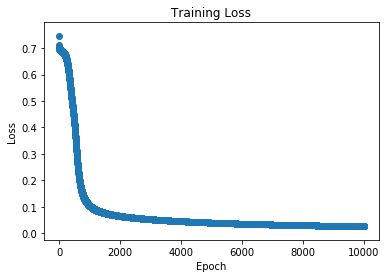

In [23]:
epochs = 10000
epsilon = 1
initial_weights = copy.deepcopy(weights)

losses = []
for epoch in range(epochs):
    gradients, L = back_propagation(X, Y, weights)
    for weight_name in weights:
        weights[weight_name] -= epsilon * gradients[weight_name]
        
    losses.append(L)
    
plt.scatter(range(epochs), losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

As we can see in the plot above where the loss is plotted with respect to the number of epochs the network experienced, we clearly observed a decrease of the loss. In other words, the network seems to make less and less errors. In other words, it learns something.

### Visualize what the network learned
Before to see what the network learned, it would be interesting to see how the initial weights of the network would perform.

In [24]:
def visualization(weights, X_data, title, superposed_training=False):
    N_test_points = 1000
    xs = np.linspace(1.1*np.min(X_data), 1.1*np.max(X_data), N_test_points)
    datapoints = np.transpose([np.tile(xs, len(xs)), np.repeat(xs, len(xs))])
    Y_initial = forward_propagation(datapoints, weights)[0].reshape(N_test_points, N_test_points)
    X1, X2 = np.meshgrid(xs, xs)
    plt.pcolormesh(X1, X2, Y_initial)
    plt.colorbar(label='P(1)')
    if superposed_training:
        plt.scatter(X_data[:N_points//2, 0], X_data[:N_points//2, 1], color='red') 
        plt.scatter(X_data[N_points//2:, 0], X_data[N_points//2:, 1], color='blue') 
    plt.title(title)
    plt.show()

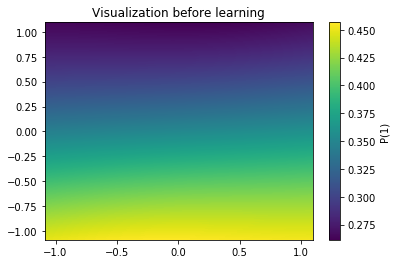

In [25]:
visualization(initial_weights, X,  'Visualization before learning')

The picture above represents as a colormap the probability of a point being of class 1. As expected, the network is completely unable yet to classify correctly. Let's visualize the same thing after learning:

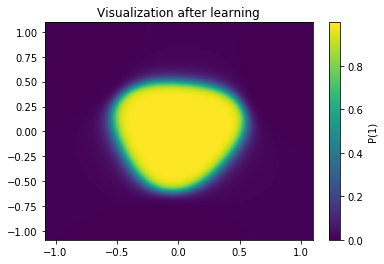

In [26]:
visualization(weights, X, 'Visualization after learning')

Now an island of class "1" lives in the middle of the map, while the rest is of class 0. If we superimpose the training samples to this visualization we realize that our network did a pretty good job classifying this map.

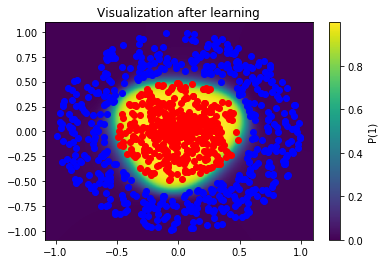

In [27]:
visualization(weights, X, 'Visualization after learning', superposed_training=True)

### With a XOR like distribution
Let's try our implementation with another distribution. 

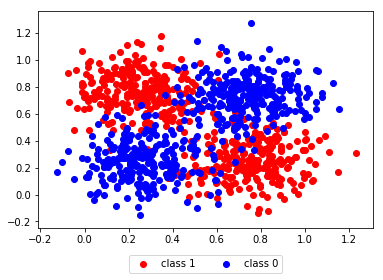

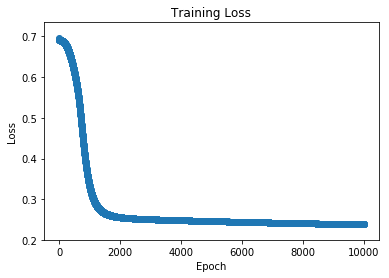

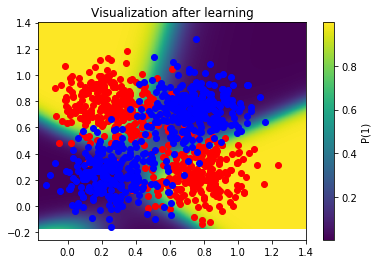

In [36]:
def generate_xor_like_dataset(N_points):
    data = []
    labels = []
    
    # 1 class
    x_1 = np.concatenate(
        (np.concatenate(
            (np.random.normal(0.25, 0.15, size=N_points//4).reshape(N_points//4,1), 
             np.random.normal(0.75, 0.15, size=N_points//4).reshape(N_points//4,1)), 
            axis=1),
        np.concatenate(
            (np.random.normal(0.75, 0.15, size=N_points//4).reshape(N_points//4,1), 
             np.random.normal(0.25, 0.15, size=N_points//4).reshape(N_points//4,1)), 
            axis=1))
    )
    y_1 = np.full((N_points//2,), 1)
        
    # 0 class
    x_2 = np.concatenate(
        (np.concatenate(
            (np.random.normal(0.25, 0.15, size=N_points//4).reshape(N_points//4,1), 
             np.random.normal(0.25, 0.15, size=N_points//4).reshape(N_points//4,1)), 
            axis=1),
        np.concatenate(
            (np.random.normal(0.75, 0.15, size=N_points//4).reshape(N_points//4,1), 
             np.random.normal(0.75, 0.15, size=N_points//4).reshape(N_points//4,1)), 
            axis=1))
    )
    y_2 = np.full((N_points//2,), 0)
        
    X = np.concatenate((x_1, x_2), axis=0)
    Y = np.concatenate((y_1, y_2), axis=0)
    return X, Y
    
xor_X, xor_Y = generate_xor_like_dataset(N_points)

plt.scatter(xor_X[:N_points//2, 0], xor_X[:N_points//2, 1], color='red', label='class 1') 
plt.scatter(xor_X[N_points//2:, 0], xor_X[N_points//2:, 1], color='blue', label='class 0')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()

xor_weights = {
    'W1': np.random.randn(3, 2),
    'b1': np.zeros(3),
    'W2': np.random.randn(3),
    'b2': 0,
}
xor_initial_weights = copy.deepcopy(xor_weights)
xor_losses = []
for epoch in range(epochs):
    gradients, L = back_propagation(xor_X, xor_Y, xor_weights)
    for weight_name in xor_weights:
        xor_weights[weight_name] -= epsilon * gradients[weight_name]
        
    xor_losses.append(L)
    
plt.scatter(range(epochs), xor_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

visualization(xor_weights, xor_X, 'Visualization after learning', superposed_training=True)

## Conclusion
As a conclusion, backpropagation is not an extremely complicated algorithm, and as we have seen above, it is pretty straightforward to derive a bare numpy implementation for it. Although it comes generally for given while using most of the deep learning frameworks, it is a good idea to get your hands dirty and understand a little bit more what it does. In some occasions, it might help you to understand why your network is not "learning" properly.